## Water transport across several cross-sections 

Transports across several cross sections in the domain (See plot further down)

Water transport calclated as $\vec{v}A$


In [1]:
import glob
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import xarray as xr


In [2]:
sns.set_style(style='whitegrid')
sns.set_context('paper')

In [3]:
def calc_wat_transport_CS(flux_component,area, x_slice, y_slice, dim_name):
    '''
    INPUT:
    flux_component: xarray, flux component perpendicular to cross section (e.g. unstagger_xarray(flux38.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    dim_name: str, name of the dimension along which to sum.
    
    '''
    area_exp = exp_dims(area,0)
    area_exp = area_exp + np.zeros(np.shape(flux_component.data))
    
    return (flux_component.isel(Yp1=y_slice, X=x_slice).data*area_exp[:,y_slice,x_slice]).sum(dim=dim_name)

   
def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

In [4]:
import os
import sys
lib_path = os.path.abspath('../PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
import nocanyon_records

In [5]:
records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [6]:
# Definitions of cross-sections
CS1_x_slice = slice(0, 60)
CS2_x_slice = slice(60, 120)
CS3_x_slice = slice(120, 240)
CS4_x_slice = slice(240, 300)
CS5_x_slice = slice(300, 359)

LID_x_slice = slice(120,240)
LID_y_slice = slice(227,267)
LID_z_index = 29

CS_y_index = 227

CS_z_slice = slice(0,30)
CS_deep_slice = slice(30,90)

COAST_y_index = 358
COAST_x_slice = slice(0,359)

grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
state = xr.open_dataset(state_file)


### Cross-section locations

(-550, 0)

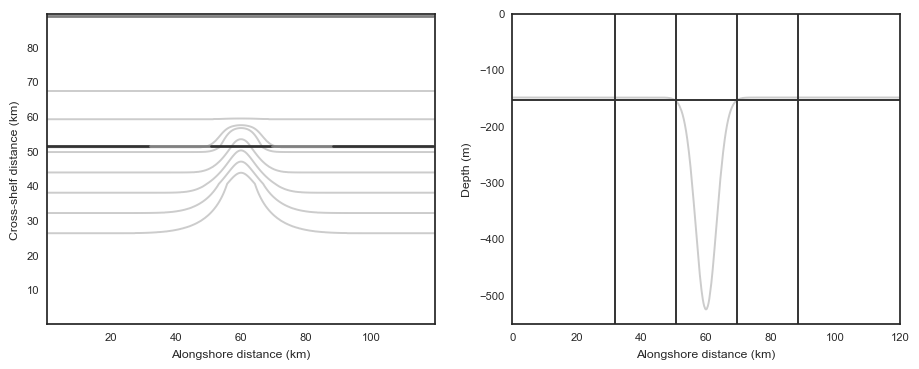

In [7]:
sns.set_style(style='white')
fig, ax = plt.subplots(1, 2, figsize=(11,4))

cnt = ax[0].contour(grid.X/1000,grid.Y/1000,grid.Depth,[50,100,150,200,400,600,800,1000], colors='0.8')
ax[0].plot(grid.X[CS1_x_slice]/1000,grid.Y[CS_y_index].data*np.ones(np.shape(grid.X[CS1_x_slice]))/1000,
           '-', color='0.2',linewidth=2)
ax[0].plot(grid.X[CS2_x_slice]/1000,grid.Y[CS_y_index].data*np.ones(np.shape(grid.X[CS2_x_slice]))/1000,
           '-', color='0.5',linewidth=2)
ax[0].plot(grid.X[CS3_x_slice]/1000,grid.Y[CS_y_index].data*np.ones(np.shape(grid.X[CS3_x_slice]))/1000,
           '-', color='0.2',linewidth=2)
ax[0].plot(grid.X[CS4_x_slice]/1000,grid.Y[CS_y_index].data*np.ones(np.shape(grid.X[CS4_x_slice]))/1000,
           '-', color='0.5',linewidth=2)
ax[0].plot(grid.X[CS5_x_slice]/1000,grid.Y[CS_y_index].data*np.ones(np.shape(grid.X[CS5_x_slice]))/1000,
           '-', color='0.2',linewidth=2)
ax[0].plot(grid.X[COAST_x_slice]/1000,grid.Y[COAST_y_index].data*np.ones(np.shape(grid.X[COAST_x_slice]))/1000,
           '-', color='0.5',linewidth=2)


ax[0].set_ylabel('Cross-shelf distance (km)')
ax[0].set_xlabel('Alongshore distance (km)')

ax[1].plot(grid.X/1000,-grid.Depth[CS_y_index,:],'-', color='0.8' )
ax[1].axvline(x=grid.X[60]/1000, color='0.2')
ax[1].axvline(x=grid.X[120]/1000, color='0.2')
ax[1].axvline(x=grid.X[240]/1000, color='0.2')
ax[1].axvline(x=grid.X[300]/1000, color='0.2')
ax[1].axhline(y=grid.RC[30], color='0.2')

ax[1].set_ylabel('Depth (m)')
ax[1].set_xlabel('Alongshore distance (km)')
ax[1].set_ylim(-550,0)


In [8]:
# Get timeseries of tracer transport through each section for each run

for rec in records:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/stateGlob.nc' %(rec.exp_code,rec.run_num))
    fluxData = xr.open_dataset(filename)
    
    rec.advCS1_flux = calc_wat_transport_CS(unstagger_xarray(fluxData.V.isel(Z=CS_z_slice),'Yp1'),
                                         CS1_x_slice, CS_y_index, 'X').sum(dim='Z')
    rec.advCS2_flux = calc_wat_transport_CS(unstagger_xarray(fluxData.V.isel(Z=CS_z_slice),'Yp1'),
                                         CS2_x_slice, CS_y_index, 'X').sum(dim='Z')
    rec.advCS3_flux = calc_wat_transport_CS(unstagger_xarray(fluxData.V.isel(Z=CS_z_slice),'Yp1'),
                                         CS3_x_slice, CS_y_index, 'X').sum(dim='Z')
    
    rec.advCS3d_flux = calc_wat_transport_CS(unstagger_xarray(fluxData.V.isel(Z=CS_deep_slice),'Yp1'),
                                         CS3_x_slice, CS_y_index, 'X').sum(dim='Z')
    rec.advCS4_flux = calc_wat_transport_CS(unstagger_xarray(fluxData.V.isel(Z=CS_z_slice),'Yp1'),
                                         CS4_x_slice, CS_y_index, 'X').sum(dim='Z')
    rec.advCS5_flux = calc_wat_transport_CS(unstagger_xarray(fluxData.V.isel(Z=CS_z_slice),'Yp1'),
                                         CS5_x_slice, CS_y_index, 'X').sum(dim='Z')

    rec.advCSCoast_flux = calc_wat_transport_CS(unstagger_xarray(fluxData.V.isel(Z=CS_z_slice),'Yp1'),
                                         COAST_x_slice, COAST_y_index, 'X').sum(dim='Z')


In [9]:
for rec in recordsNoC:
    
    filenameNoC=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/stateGlob.nc' %(rec.exp_code,rec.run_num))
    fluxDataNoC = xr.open_dataset(filenameNoC)

    rec.advCS1_flux = calc_wat_transport_CS(unstagger_xarray(fluxDataNoC.V.isel(Z=CS_z_slice),'Yp1'),
                                         CS1_x_slice, CS_y_index, 'X').sum(dim='Z')
    rec.advCS2_flux = calc_wat_transport_CS(unstagger_xarray(fluxDataNoC.V.isel(Z=CS_z_slice),'Yp1'),
                                         CS2_x_slice, CS_y_index, 'X').sum(dim='Z')
    rec.advCS3_flux = calc_wat_transport_CS(unstagger_xarray(fluxDataNoC.V.isel(Z=CS_z_slice),'Yp1'),
                                         CS3_x_slice, CS_y_index, 'X').sum(dim='Z')
    rec.advCS3d_flux = calc_wat_transport_CS(unstagger_xarray(fluxDataNoC.V.isel(Z=CS_deep_slice),'Yp1'),
                                         CS3_x_slice, CS_y_index, 'X').sum(dim='Z')
    rec.advCS4_flux = calc_wat_transport_CS(unstagger_xarray(fluxDataNoC.V.isel(Z=CS_z_slice),'Yp1'),
                                         CS4_x_slice, CS_y_index, 'X').sum(dim='Z')
    rec.advCS5_flux = calc_wat_transport_CS(unstagger_xarray(fluxDataNoC.V.isel(Z=CS_z_slice),'Yp1'),
                                         CS5_x_slice, CS_y_index, 'X').sum(dim='Z')
    rec.advCSCoast_flux = calc_wat_transport_CS(unstagger_xarray(fluxData.V.isel(Z=CS_z_slice),'Yp1'),
                                         COAST_x_slice, COAST_y_index, 'X').sum(dim='Z')


In [10]:
# Get timeseries of tracer transport through each section for each run

for rec in records:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/stateGlob.nc' %(rec.exp_code,rec.run_num))
    fluxData = xr.open_dataset(filename)
    
    rec.advLID_flux = (unstagger_xarray(fluxData.ADVrTr01,'Zl').isel(Zl=29, 
                                                                            X= slice(120,240), 
                                                                            Y=slice(229,267))).sum(dim='X').sum(dim='Y')
   
    

### Plot all sections 

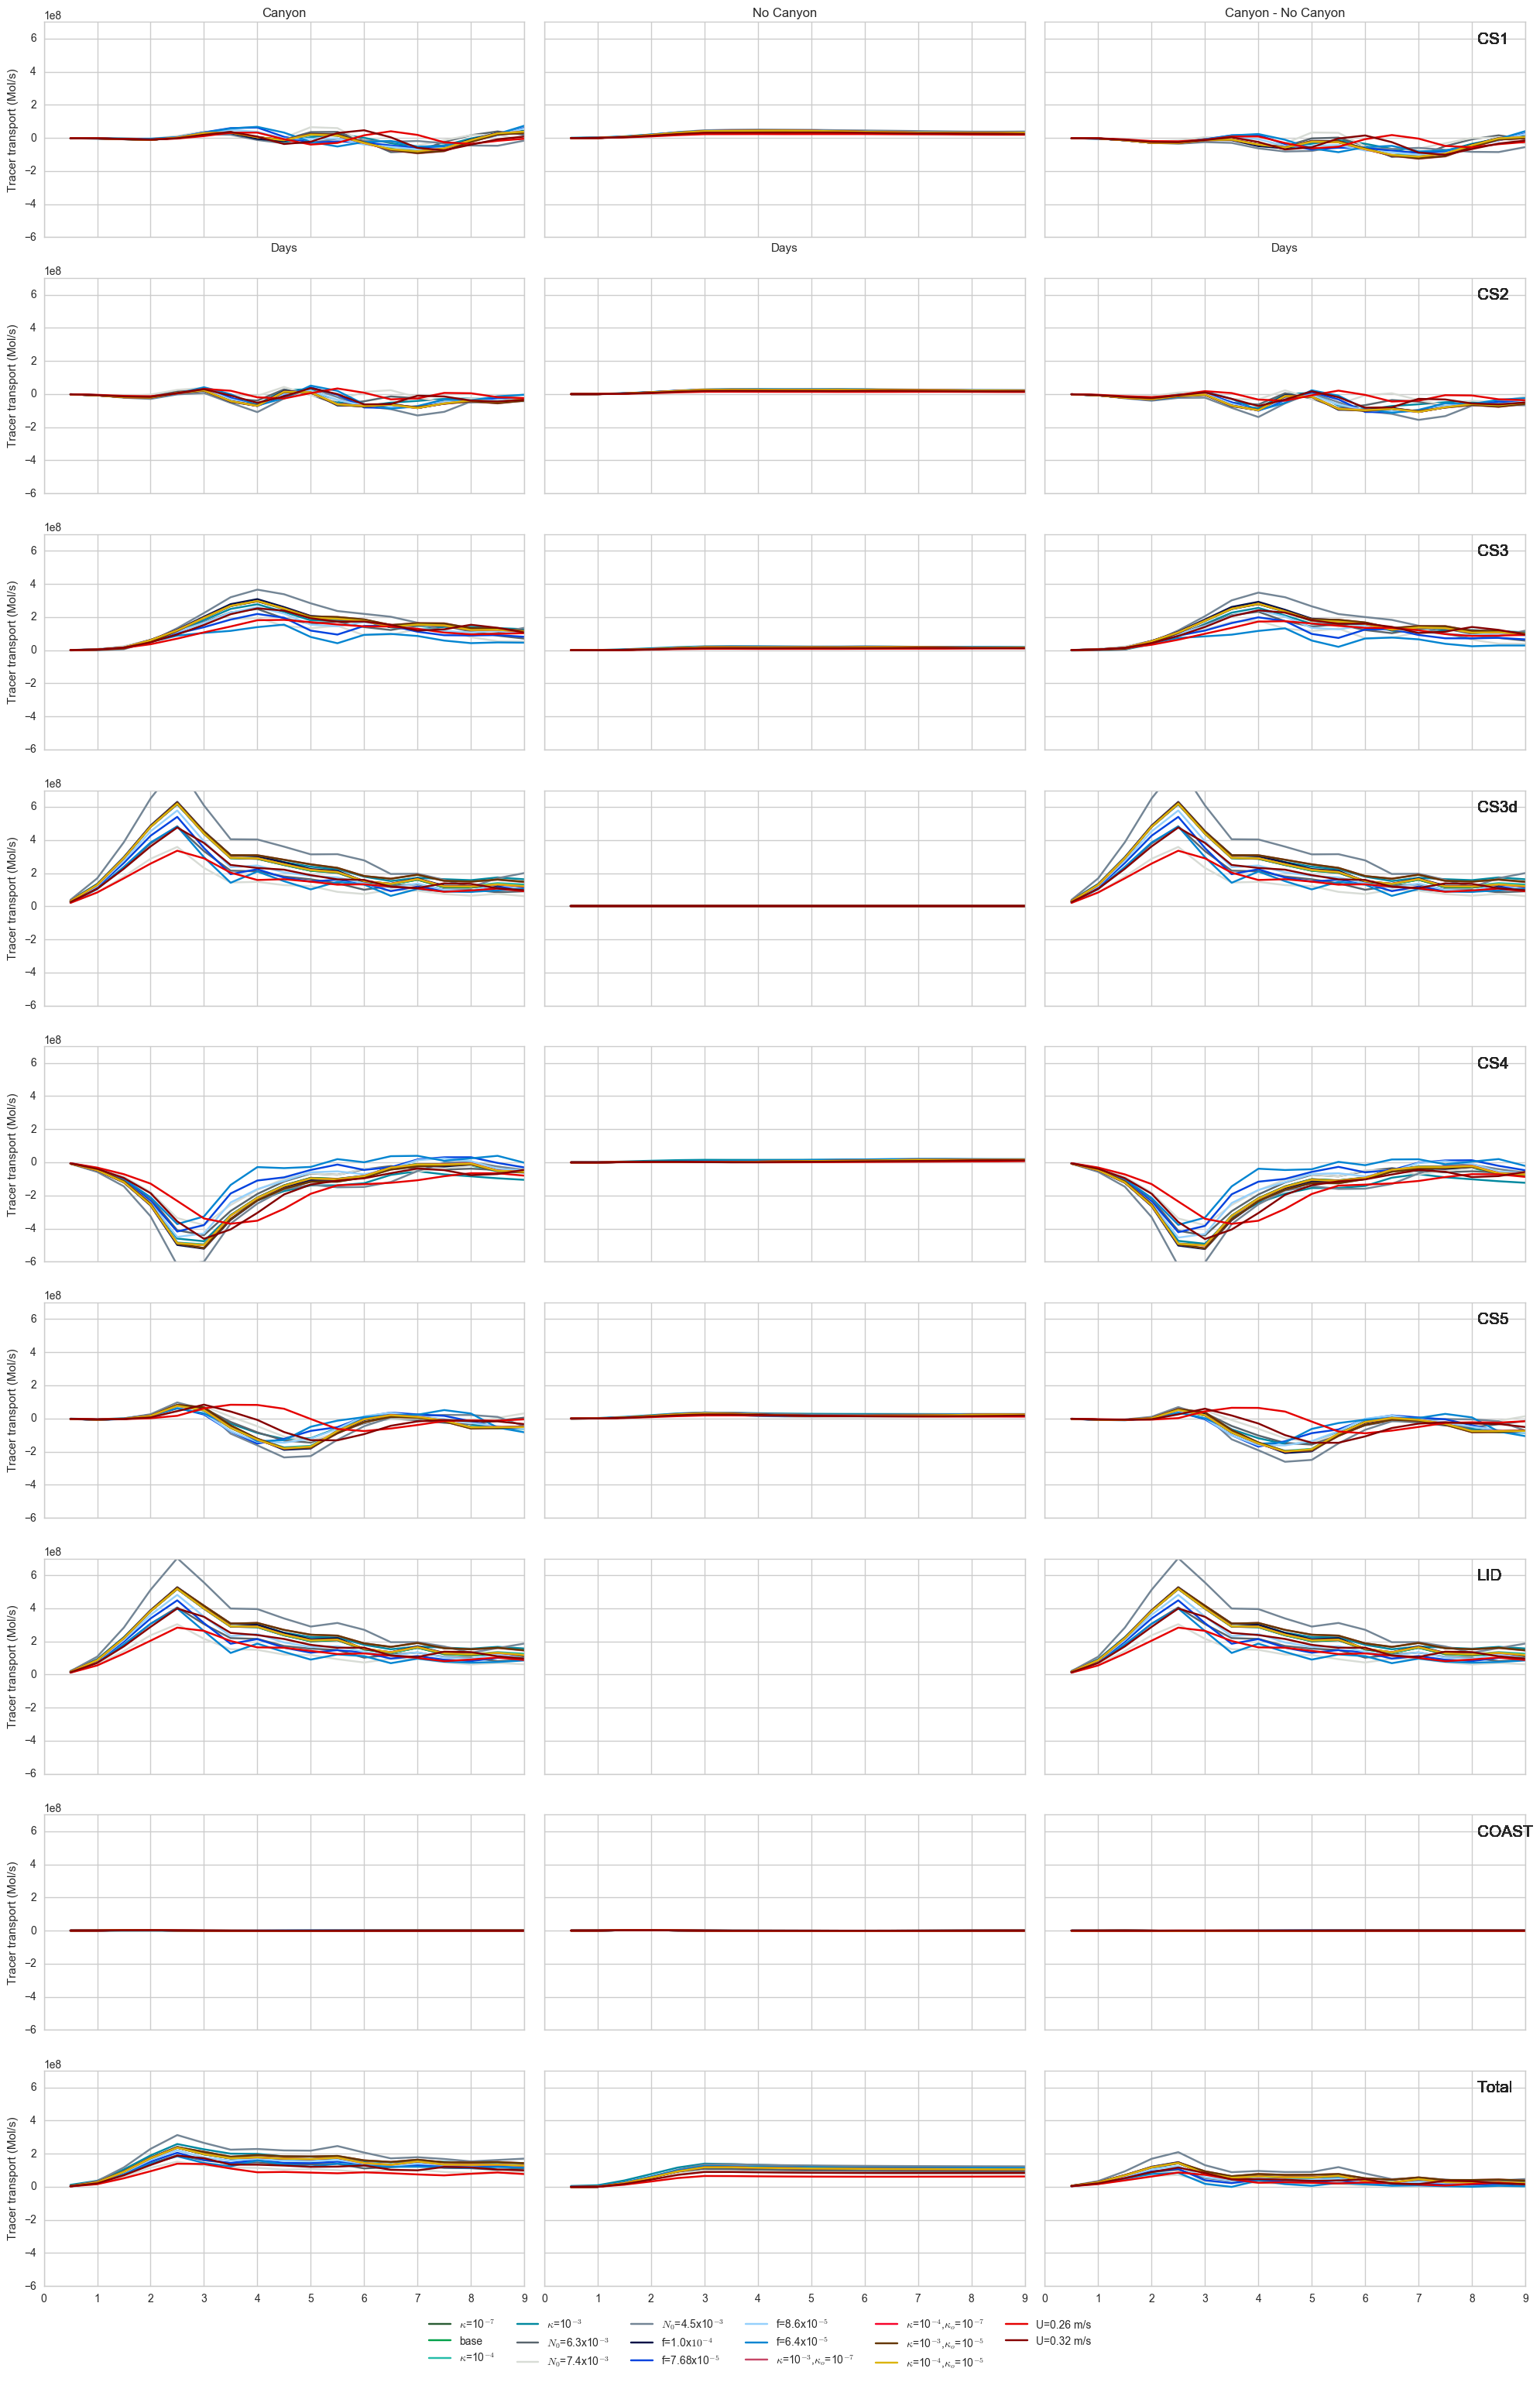

In [25]:
sns.set_context('notebook')
sns.set_style('whitegrid')

fig, ax = plt.subplots(9, 3, figsize=(20,30),sharex=True,sharey=True)

time_vec = np.arange(1,19,1)/(2)

for rec,recNoC in zip(records,recordsNoC):
    
    ax[0,0].plot(time_vec,rec.advCS1_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[0,2].text(0.9, 0.9, 'CS1',transform=ax[0,2].transAxes, fontsize=15)
    ax[0,1].plot(time_vec,recNoC.advCS1_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[0,2].plot(time_vec,(rec.advCS1_flux.data-recNoC.advCS1_flux.data)*1000,'-',color=sns.xkcd_rgb[rec.color],label=rec.label)
    
    ax[1,0].plot(time_vec,rec.advCS2_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[1,1].plot(time_vec,recNoC.advCS2_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[1,2].plot(time_vec,(rec.advCS2_flux.data-recNoC.advCS2_flux.data)*1000,'-',color=sns.xkcd_rgb[rec.color],label=rec.label)
    ax[1,2].text(0.9, 0.9, 'CS2',transform=ax[1,2].transAxes, fontsize=15)
    
    ax[2,0].plot(time_vec,rec.advCS3_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[2,1].plot(time_vec,recNoC.advCS3_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[2,2].plot(time_vec,(rec.advCS3_flux.data-recNoC.advCS3_flux.data)*1000,'-',color=sns.xkcd_rgb[rec.color],label=rec.label)
    ax[2,2].text(0.9, 0.9, 'CS3',transform=ax[2,2].transAxes, fontsize=15)
    
    ax[3,0].plot(time_vec,rec.advCS3d_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[3,1].plot(time_vec,recNoC.advCS3d_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[3,2].plot(time_vec,(rec.advCS3d_flux.data-recNoC.advCS3d_flux.data)*1000,'-',color=sns.xkcd_rgb[rec.color],label=rec.label)
    ax[3,2].text(0.9, 0.9, 'CS3d',transform=ax[3,2].transAxes, fontsize=15)
    
    ax[4,0].plot(time_vec,rec.advCS4_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[4,1].plot(time_vec,recNoC.advCS4_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[4,2].plot(time_vec,(rec.advCS4_flux.data-recNoC.advCS4_flux.data)*1000,'-',color=sns.xkcd_rgb[rec.color],label=rec.label)
    ax[4,2].text(0.9, 0.9, 'CS4',transform=ax[4,2].transAxes, fontsize=15)
    
    ax[5,0].plot(time_vec,rec.advCS5_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[5,1].plot(time_vec,recNoC.advCS5_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[5,2].plot(time_vec,(rec.advCS5_flux.data-recNoC.advCS5_flux.data)*1000,'-',color=sns.xkcd_rgb[rec.color],label=rec.label)
    ax[5,2].text(0.9, 0.9, 'CS5',transform=ax[5,2].transAxes, fontsize=15)
    
    ax[6,0].plot(time_vec,(rec.advLID_flux.data+
                           rec.diffELID_flux.data+
                           rec.diffILID_flux.data)*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[6,2].plot(time_vec,(rec.advLID_flux.data+
                           rec.diffELID_flux.data+
                           rec.diffILID_flux.data)*1000,'-',color=sns.xkcd_rgb[rec.color],label=rec.label)
    ax[6,2].text(0.9, 0.9, 'LID',transform=ax[6,2].transAxes, fontsize=15)
    
    ax[7,0].plot(time_vec,rec.advCSCoast_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[7,1].plot(time_vec,recNoC.advCSCoast_flux*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[7,2].plot(time_vec,(rec.advCSCoast_flux.data-recNoC.advCSCoast_flux.data)*1000,'-',color=sns.xkcd_rgb[rec.color],label=rec.label)
    ax[7,2].text(0.9, 0.9, 'COAST',transform=ax[7,2].transAxes, fontsize=15)
    
    total = (rec.advCS1_flux.data+
             rec.advCS2_flux.data+
             rec.advCS3_flux.data+
             rec.advLID_flux+
             rec.diffELID_flux+
             rec.diffILID_flux+
             rec.advCS4_flux.data+
             rec.advCS5_flux.data+
             rec.advCSCoast_flux.data)
    totalNoC = (recNoC.advCS1_flux.data+
             recNoC.advCS2_flux.data+
             recNoC.advCS3_flux.data+
             recNoC.advCS4_flux.data+
             recNoC.advCS5_flux.data+
             recNoC.advCSCoast_flux.data)
    
    ax[8,0].plot(time_vec,total*1000,'-',color=sns.xkcd_rgb[rec.color],label=rec.label)
    ax[8,1].plot(time_vec,totalNoC*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[8,2].plot(time_vec,(total-totalNoC)*1000,'-',color=sns.xkcd_rgb[rec.color])
    ax[8,2].text(0.9, 0.9, 'Total',transform=ax[8,2].transAxes, fontsize=15)
    
ax[0,0].set_title('Canyon')
ax[0,1].set_title('No Canyon')
ax[0,2].set_title('Canyon - No Canyon')

ax[0,0].set_xlabel('Days')
ax[0,1].set_xlabel('Days')
ax[0,2].set_xlabel('Days')

ax[0,0].set_ylabel('Tracer transport (Mol/s)')
ax[1,0].set_ylabel('Tracer transport (Mol/s)')
ax[2,0].set_ylabel('Tracer transport (Mol/s)')
ax[3,0].set_ylabel('Tracer transport (Mol/s)')
ax[4,0].set_ylabel('Tracer transport (Mol/s)')
ax[5,0].set_ylabel('Tracer transport (Mol/s)')
ax[6,0].set_ylabel('Tracer transport (Mol/s)')
ax[7,0].set_ylabel('Tracer transport (Mol/s)')
ax[8,0].set_ylabel('Tracer transport (Mol/s)')

ax[0,0].set_ylim(-6.0E8,7E8)
ax[8,0].legend(bbox_to_anchor=(2.2,-0.1),ncol=6)
plt.tight_layout()
plt.show()

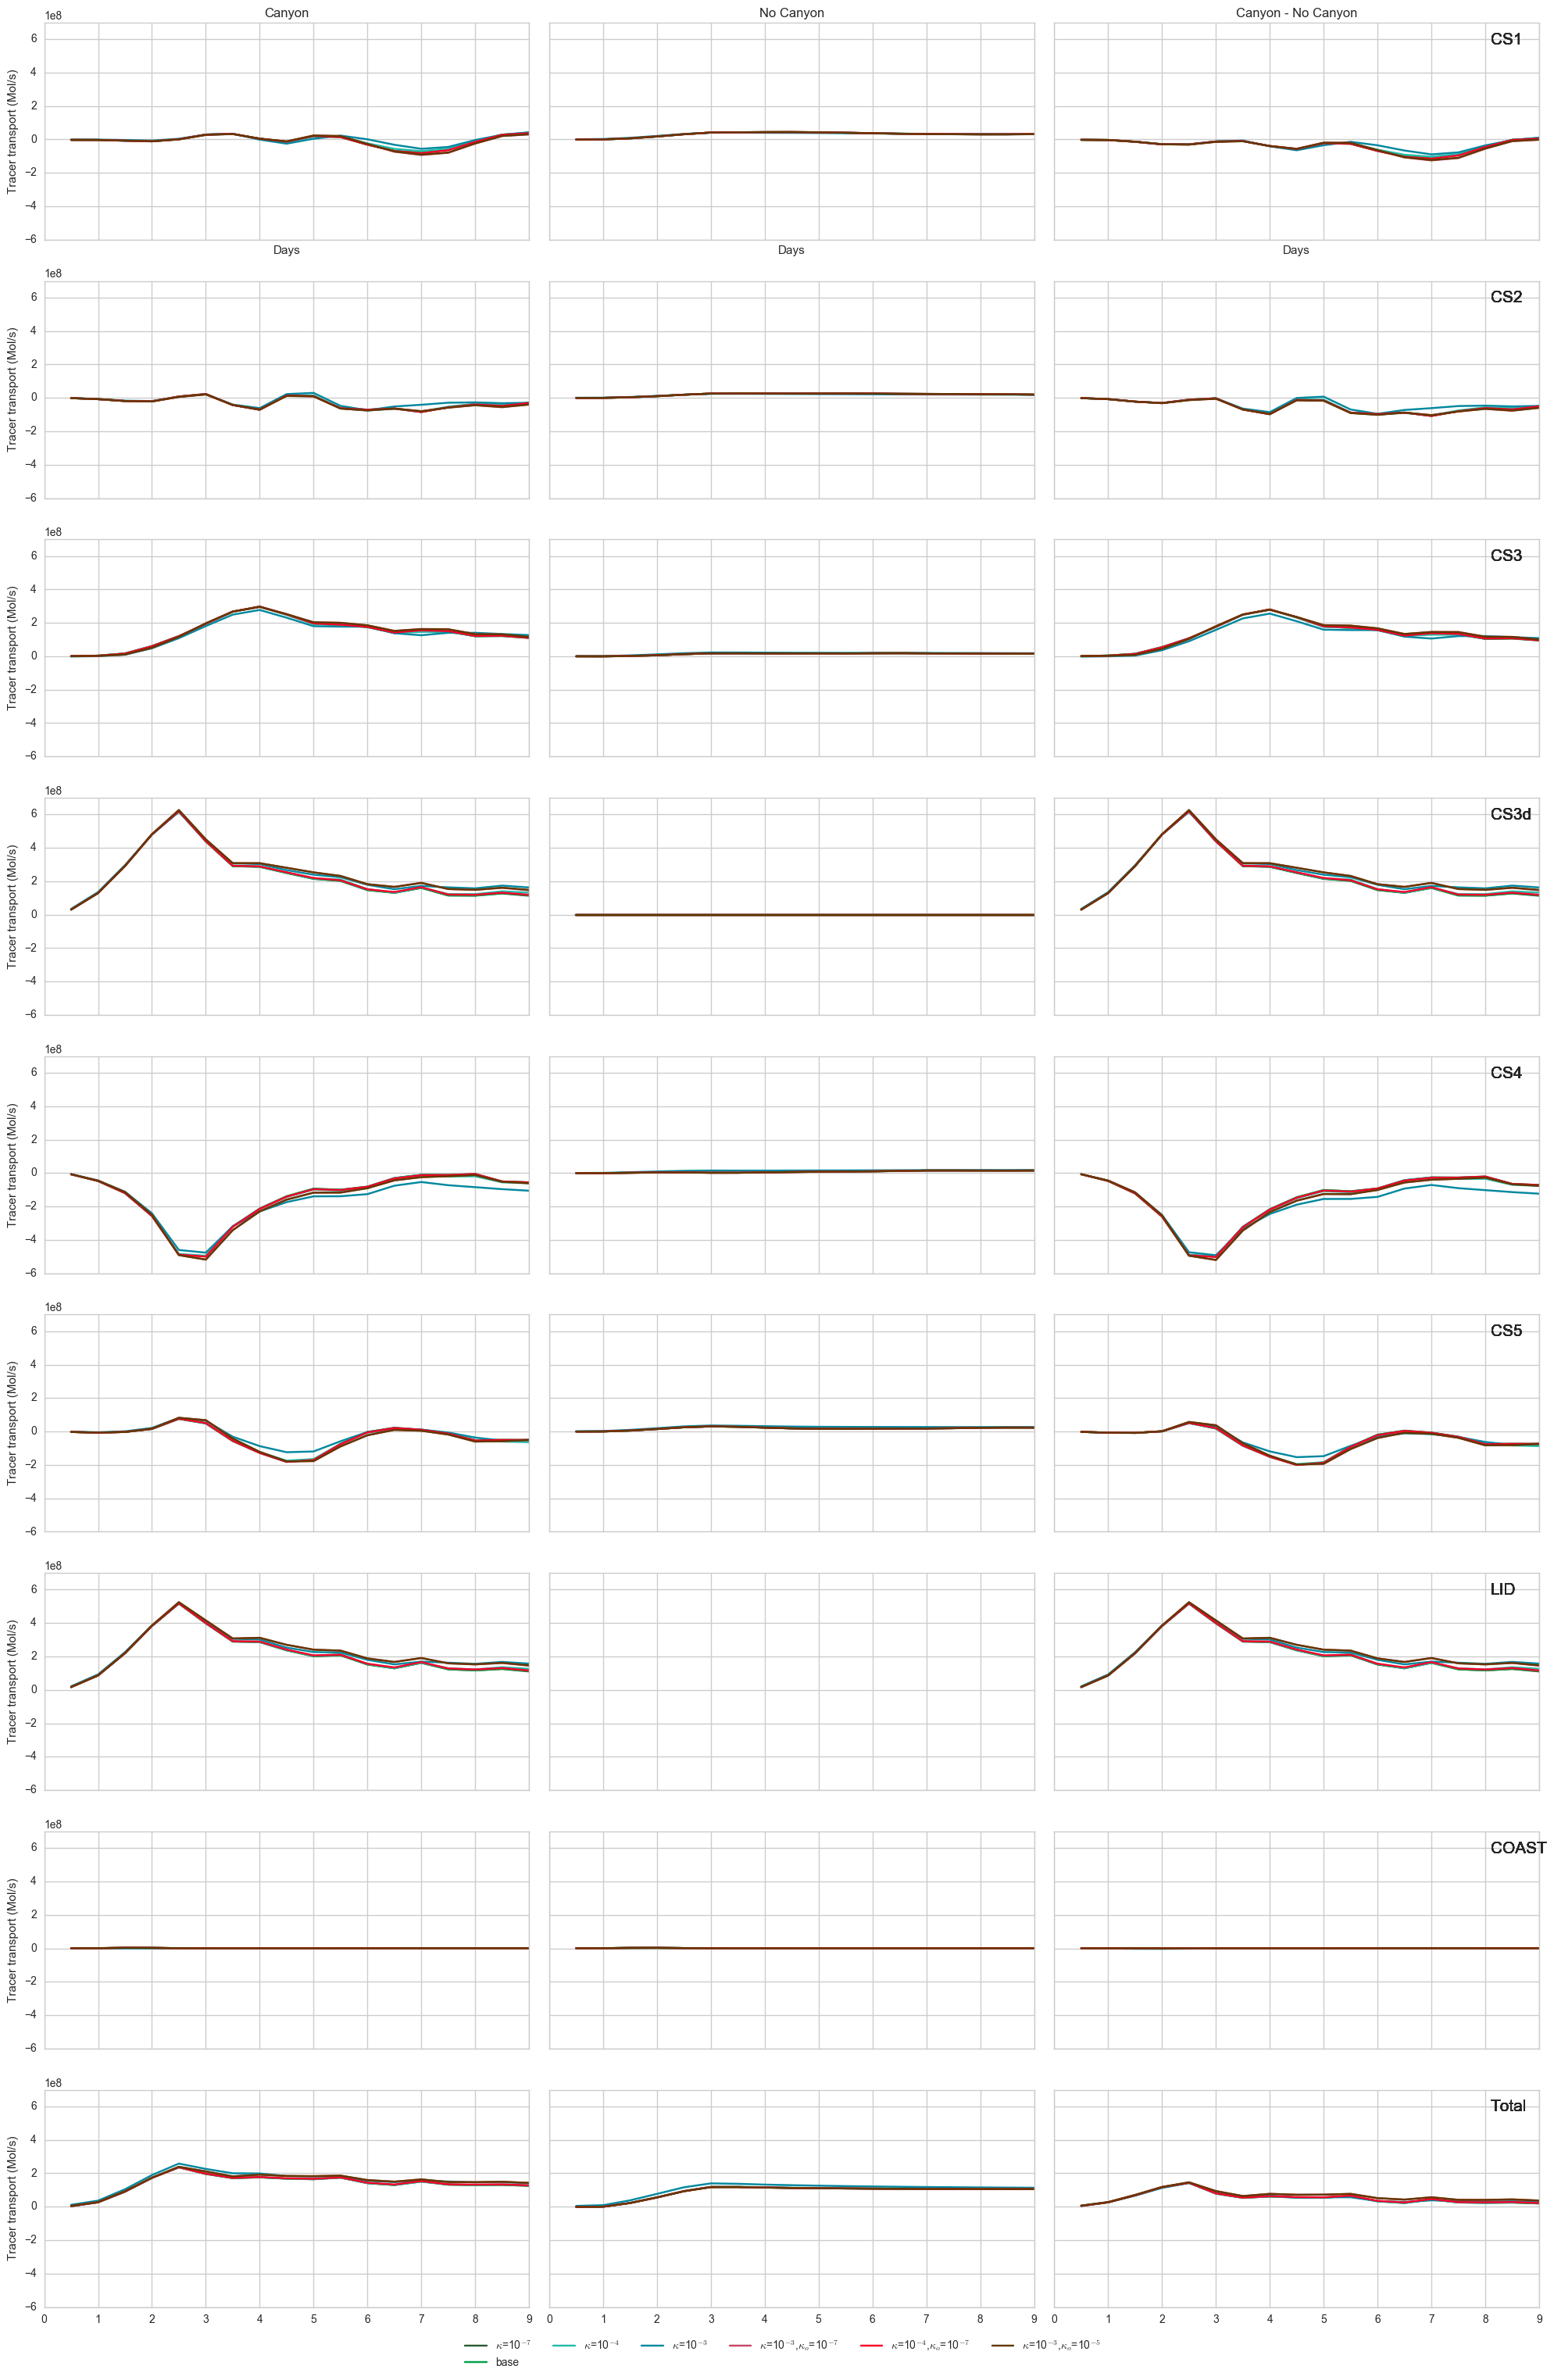

In [39]:
sns.set_context('notebook')
sns.set_style('whitegrid')

fig, ax = plt.subplots(9, 3, figsize=(20,30),sharex=True,sharey=True)

time_vec = np.arange(1,19,1)/(2)

for ind in diff_ind:
    
    ax[0,0].plot(time_vec,records[ind].advCS1_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[0,2].text(0.9, 0.9, 'CS1',transform=ax[0,2].transAxes, fontsize=15)
    ax[0,1].plot(time_vec,recordsNoC[ind].advCS1_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[0,2].plot(time_vec,(records[ind].advCS1_flux.data-recordsNoC[ind].advCS1_flux.data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    
    ax[1,0].plot(time_vec,records[ind].advCS2_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[1,1].plot(time_vec,recordsNoC[ind].advCS2_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[1,2].plot(time_vec,(records[ind].advCS2_flux.data-recordsNoC[ind].advCS2_flux.data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[1,2].text(0.9, 0.9, 'CS2',transform=ax[1,2].transAxes, fontsize=15)
    
    ax[2,0].plot(time_vec,records[ind].advCS3_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[2,1].plot(time_vec,recordsNoC[ind].advCS3_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[2,2].plot(time_vec,(records[ind].advCS3_flux.data-recordsNoC[ind].advCS3_flux.data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[2,2].text(0.9, 0.9, 'CS3',transform=ax[2,2].transAxes, fontsize=15)
    
    ax[3,0].plot(time_vec,records[ind].advCS3d_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[3,1].plot(time_vec,recordsNoC[ind].advCS3d_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[3,2].plot(time_vec,(records[ind].advCS3d_flux.data-recordsNoC[ind].advCS3d_flux.data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[3,2].text(0.9, 0.9, 'CS3d',transform=ax[3,2].transAxes, fontsize=15)
    
    ax[4,0].plot(time_vec,records[ind].advCS4_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[4,1].plot(time_vec,recordsNoC[ind].advCS4_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[4,2].plot(time_vec,(records[ind].advCS4_flux.data-recordsNoC[ind].advCS4_flux.data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[4,2].text(0.9, 0.9, 'CS4',transform=ax[4,2].transAxes, fontsize=15)
    
    ax[5,0].plot(time_vec,records[ind].advCS5_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[5,1].plot(time_vec,recordsNoC[ind].advCS5_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[5,2].plot(time_vec,(records[ind].advCS5_flux.data-recordsNoC[ind].advCS5_flux.data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[5,2].text(0.9, 0.9, 'CS5',transform=ax[5,2].transAxes, fontsize=15)
    
    ax[6,0].plot(time_vec,(records[ind].advLID_flux.data+
                           records[ind].diffELID_flux.data+
                           records[ind].diffILID_flux.data)*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[6,2].plot(time_vec,(records[ind].advLID_flux.data+
                           records[ind].diffELID_flux.data+
                           records[ind].diffILID_flux.data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[6,2].text(0.9, 0.9, 'LID',transform=ax[6,2].transAxes, fontsize=15)
    
    ax[7,0].plot(time_vec,records[ind].advCSCoast_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[7,1].plot(time_vec,recordsNoC[ind].advCSCoast_flux*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[7,2].plot(time_vec,(records[ind].advCSCoast_flux.data-recordsNoC[ind].advCSCoast_flux.data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[7,2].text(0.9, 0.9, 'COAST',transform=ax[7,2].transAxes, fontsize=15)
    
    total = (records[ind].advCS1_flux.data+
             records[ind].advCS2_flux.data+
             records[ind].advCS3_flux.data+
             records[ind].advLID_flux+
             records[ind].diffELID_flux+
             records[ind].diffILID_flux+
             records[ind].advCS4_flux.data+
             records[ind].advCS5_flux.data+
             records[ind].advCSCoast_flux.data)
    totalNoC = (recordsNoC[ind].advCS1_flux.data+
             recordsNoC[ind].advCS2_flux.data+
             recordsNoC[ind].advCS3_flux.data+
             recordsNoC[ind].advCS4_flux.data+
             recordsNoC[ind].advCS5_flux.data+
             recordsNoC[ind].advCSCoast_flux.data)
    
    ax[8,0].plot(time_vec,total*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[8,1].plot(time_vec,totalNoC*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[8,2].plot(time_vec,(total-totalNoC)*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[8,2].text(0.9, 0.9, 'Total',transform=ax[8,2].transAxes, fontsize=15)
    
ax[0,0].set_title('Canyon')
ax[0,1].set_title('No Canyon')
ax[0,2].set_title('Canyon - No Canyon')

ax[0,0].set_xlabel('Days')
ax[0,1].set_xlabel('Days')
ax[0,2].set_xlabel('Days')

ax[0,0].set_ylabel('Tracer transport (Mol/s)')
ax[1,0].set_ylabel('Tracer transport (Mol/s)')
ax[2,0].set_ylabel('Tracer transport (Mol/s)')
ax[3,0].set_ylabel('Tracer transport (Mol/s)')
ax[4,0].set_ylabel('Tracer transport (Mol/s)')
ax[5,0].set_ylabel('Tracer transport (Mol/s)')
ax[6,0].set_ylabel('Tracer transport (Mol/s)')
ax[7,0].set_ylabel('Tracer transport (Mol/s)')
ax[8,0].set_ylabel('Tracer transport (Mol/s)')

ax[0,0].set_ylim(-6.0E8,7E8)
ax[8,0].legend(bbox_to_anchor=(2.2,-0.1),ncol=6)
plt.tight_layout()
plt.show()

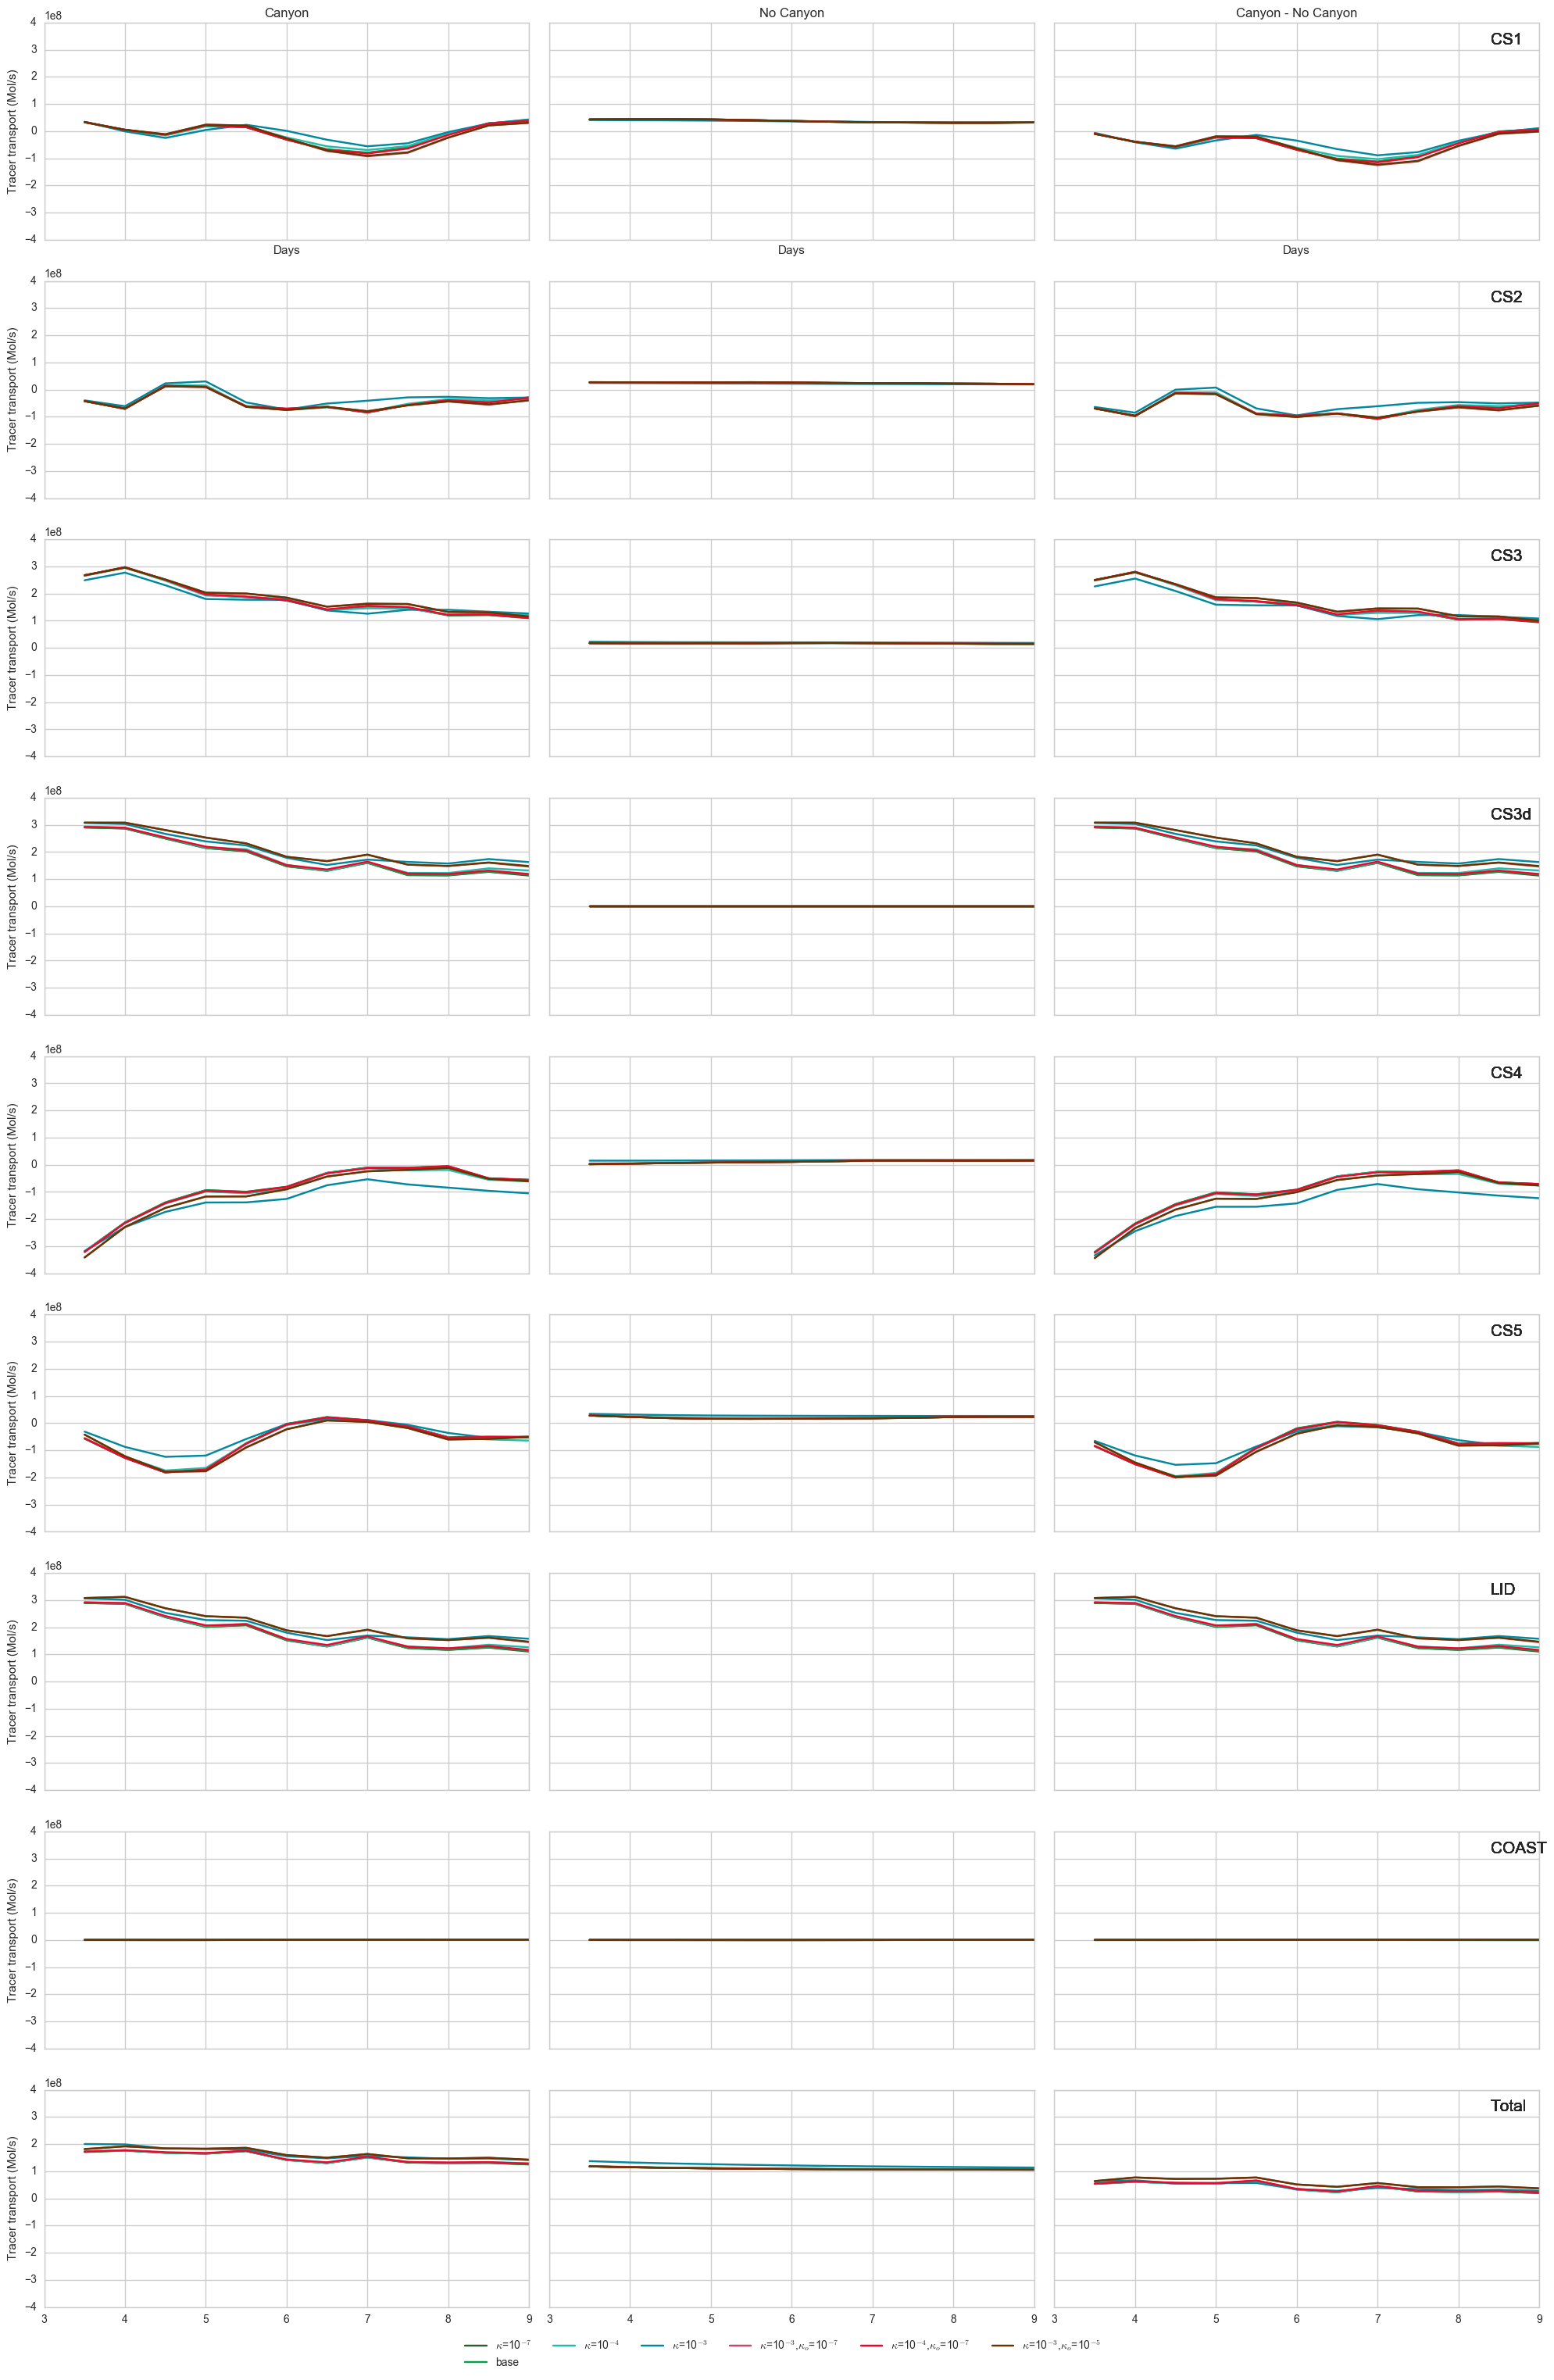

In [49]:
sns.set_context('notebook')
sns.set_style('whitegrid')

fig, ax = plt.subplots(9, 3, figsize=(20,30),sharex=True,sharey=True)

time_vec = np.arange(7,19,1)/(2)

for ind in diff_ind:
    
    ax[0,0].plot(time_vec,records[ind].advCS1_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[0,2].text(0.9, 0.9, 'CS1',transform=ax[0,2].transAxes, fontsize=15)
    ax[0,1].plot(time_vec,recordsNoC[ind].advCS1_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[0,2].plot(time_vec,(records[ind].advCS1_flux.isel(T=slice(6,19)).data-recordsNoC[ind].advCS1_flux.isel(T=slice(6,19)).data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    
    ax[1,0].plot(time_vec,records[ind].advCS2_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[1,1].plot(time_vec,recordsNoC[ind].advCS2_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[1,2].plot(time_vec,(records[ind].advCS2_flux.isel(T=slice(6,19)).data-recordsNoC[ind].advCS2_flux.isel(T=slice(6,19)).data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[1,2].text(0.9, 0.9, 'CS2',transform=ax[1,2].transAxes, fontsize=15)
    
    ax[2,0].plot(time_vec,records[ind].advCS3_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[2,1].plot(time_vec,recordsNoC[ind].advCS3_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[2,2].plot(time_vec,(records[ind].advCS3_flux.isel(T=slice(6,19)).data-recordsNoC[ind].advCS3_flux.isel(T=slice(6,19)).data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[2,2].text(0.9, 0.9, 'CS3',transform=ax[2,2].transAxes, fontsize=15)
    
    ax[3,0].plot(time_vec,records[ind].advCS3d_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[3,1].plot(time_vec,recordsNoC[ind].advCS3d_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[3,2].plot(time_vec,(records[ind].advCS3d_flux.isel(T=slice(6,19)).data-recordsNoC[ind].advCS3d_flux.isel(T=slice(6,19)).data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[3,2].text(0.9, 0.9, 'CS3d',transform=ax[3,2].transAxes, fontsize=15)
    
    ax[4,0].plot(time_vec,records[ind].advCS4_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[4,1].plot(time_vec,recordsNoC[ind].advCS4_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[4,2].plot(time_vec,(records[ind].advCS4_flux.isel(T=slice(6,19)).data-recordsNoC[ind].advCS4_flux.isel(T=slice(6,19)).data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[4,2].text(0.9, 0.9, 'CS4',transform=ax[4,2].transAxes, fontsize=15)
    
    ax[5,0].plot(time_vec,records[ind].advCS5_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[5,1].plot(time_vec,recordsNoC[ind].advCS5_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[5,2].plot(time_vec,(records[ind].advCS5_flux.isel(T=slice(6,19)).data-recordsNoC[ind].advCS5_flux.isel(T=slice(6,19)).data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[5,2].text(0.9, 0.9, 'CS5',transform=ax[5,2].transAxes, fontsize=15)
    
    ax[6,0].plot(time_vec,(records[ind].advLID_flux.isel(T=slice(6,19)).data+
                           records[ind].diffELID_flux.isel(T=slice(6,19)).data+
                           records[ind].diffILID_flux.isel(T=slice(6,19)).data)*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[6,2].plot(time_vec,(records[ind].advLID_flux.isel(T=slice(6,19)).data+
                           records[ind].diffELID_flux.isel(T=slice(6,19)).data+
                           records[ind].diffILID_flux.isel(T=slice(6,19)).data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[6,2].text(0.9, 0.9, 'LID',transform=ax[6,2].transAxes, fontsize=15)
    
    ax[7,0].plot(time_vec,records[ind].advCSCoast_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[7,1].plot(time_vec,recordsNoC[ind].advCSCoast_flux.isel(T=slice(6,19))*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[7,2].plot(time_vec,(records[ind].advCSCoast_flux.isel(T=slice(6,19)).data-recordsNoC[ind].advCSCoast_flux.isel(T=slice(6,19)).data)*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[7,2].text(0.9, 0.9, 'COAST',transform=ax[7,2].transAxes, fontsize=15)
    
    total = (records[ind].advCS1_flux.isel(T=slice(6,19)).data+
             records[ind].advCS2_flux.isel(T=slice(6,19)).data+
             records[ind].advCS3_flux.isel(T=slice(6,19)).data+
             records[ind].advLID_flux.isel(T=slice(6,19))+
             records[ind].diffELID_flux.isel(T=slice(6,19))+
             records[ind].diffILID_flux.isel(T=slice(6,19))+
             records[ind].advCS4_flux.isel(T=slice(6,19)).data+
             records[ind].advCS5_flux.isel(T=slice(6,19)).data+
             records[ind].advCSCoast_flux.isel(T=slice(6,19)).data)
    totalNoC = (recordsNoC[ind].advCS1_flux.isel(T=slice(6,19)).data+
             recordsNoC[ind].advCS2_flux.isel(T=slice(6,19)).data+
             recordsNoC[ind].advCS3_flux.isel(T=slice(6,19)).data+
             recordsNoC[ind].advCS4_flux.isel(T=slice(6,19)).data+
             recordsNoC[ind].advCS5_flux.isel(T=slice(6,19)).data+
             recordsNoC[ind].advCSCoast_flux.isel(T=slice(6,19)).data)
    
    ax[8,0].plot(time_vec,total*1000,'-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[8,1].plot(time_vec,totalNoC*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[8,2].plot(time_vec,(total-totalNoC)*1000,'-',color=sns.xkcd_rgb[records[ind].color])
    ax[8,2].text(0.9, 0.9, 'Total',transform=ax[8,2].transAxes, fontsize=15)
    
ax[0,0].set_title('Canyon')
ax[0,1].set_title('No Canyon')
ax[0,2].set_title('Canyon - No Canyon')

ax[0,0].set_xlabel('Days')
ax[0,1].set_xlabel('Days')
ax[0,2].set_xlabel('Days')

ax[0,0].set_ylabel('Tracer transport (Mol/s)')
ax[1,0].set_ylabel('Tracer transport (Mol/s)')
ax[2,0].set_ylabel('Tracer transport (Mol/s)')
ax[3,0].set_ylabel('Tracer transport (Mol/s)')
ax[4,0].set_ylabel('Tracer transport (Mol/s)')
ax[5,0].set_ylabel('Tracer transport (Mol/s)')
ax[6,0].set_ylabel('Tracer transport (Mol/s)')
ax[7,0].set_ylabel('Tracer transport (Mol/s)')
ax[8,0].set_ylabel('Tracer transport (Mol/s)')

ax[0,0].set_ylim(-4E8,4E8)
ax[8,0].legend(bbox_to_anchor=(2.2,-0.1),ncol=6)
plt.tight_layout()
plt.show()

## Vertical transport

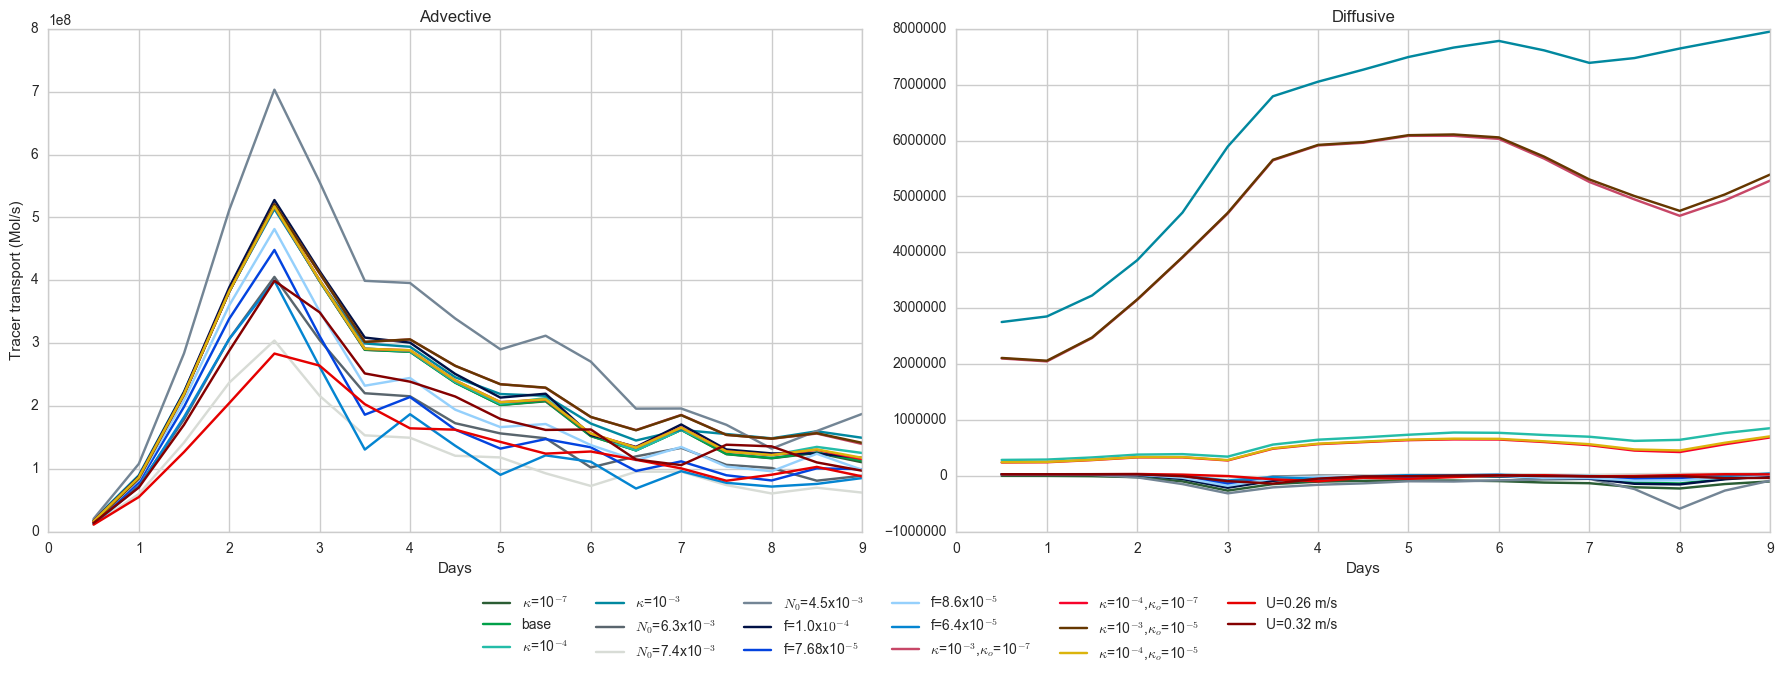

In [33]:
sns.set_context('notebook')
sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 2, figsize=(18,6))

time_vec = np.arange(1,19,1)/(2)

for rec,recNoC in zip(records,recordsNoC):
    
    ax[0].plot(time_vec,(rec.advLID_flux.data)*1000,'-',color=sns.xkcd_rgb[rec.color],label=rec.label)
    ax[1].plot(time_vec,(rec.diffELID_flux.data+rec.diffILID_flux.data)*1000,
               '-',color=sns.xkcd_rgb[rec.color],label=rec.label)
    
ax[0].set_title('Advective')
ax[1].set_title('Diffusive')

ax[0].set_xlabel('Days')
ax[1].set_xlabel('Days')

ax[0].set_ylabel('Tracer transport (Mol/s)')
ax[0].legend(bbox_to_anchor=(1.6,-0.1),ncol=6)
plt.tight_layout()
plt.show()

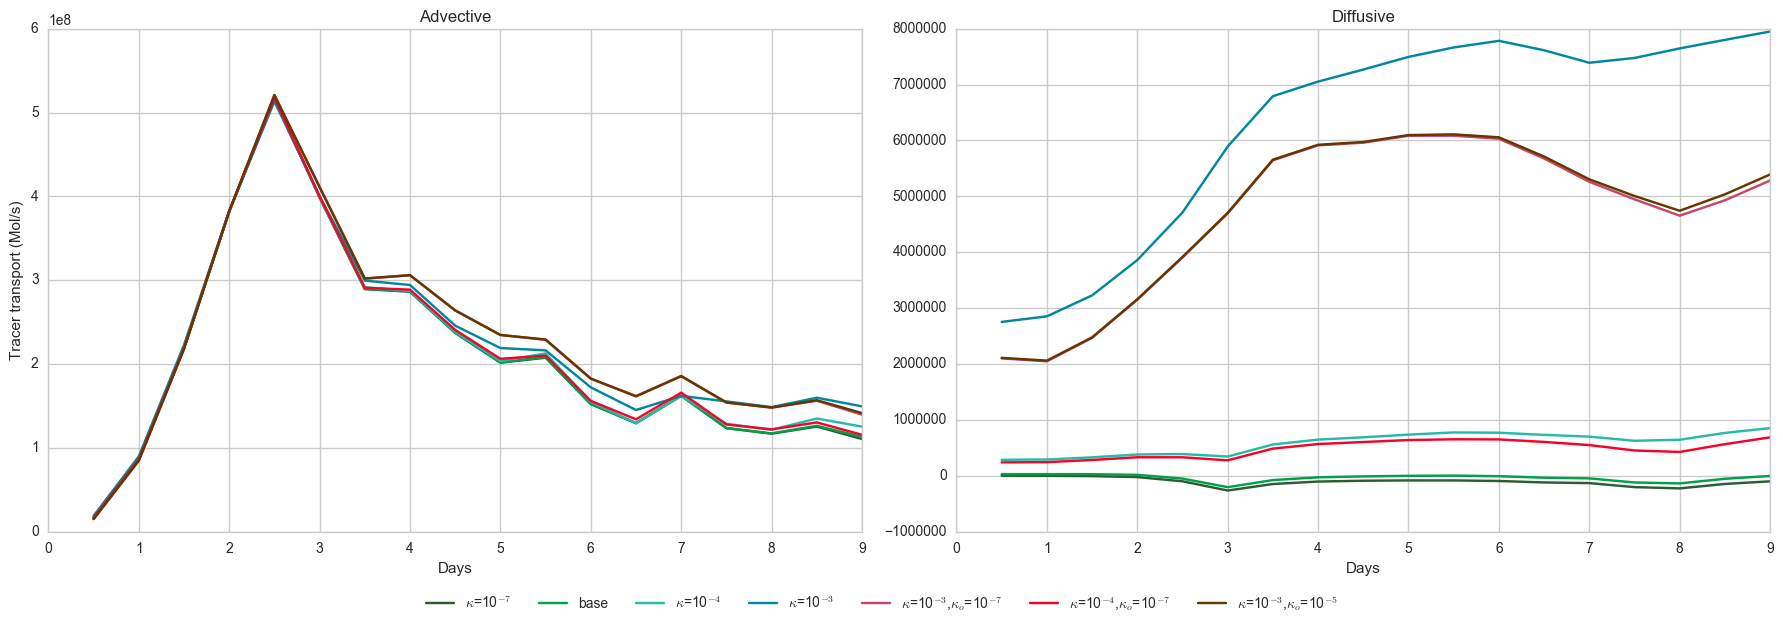

In [43]:
sns.set_context('notebook')
sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 2, figsize=(18,6))

time_vec = np.arange(1,19,1)/(2)

for ind in diff_ind:
    
    ax[0].plot(time_vec,(records[ind].advLID_flux.data)*1000,'-',
               color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[1].plot(time_vec,(records[ind].diffELID_flux.data+records[ind].diffILID_flux.data)*1000,
               '-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    
ax[0].set_title('Advective')
ax[1].set_title('Diffusive')

ax[0].set_xlabel('Days')
ax[1].set_xlabel('Days')

ax[0].set_ylabel('Tracer transport (Mol/s)')
ax[0].legend(bbox_to_anchor=(1.6,-0.1),ncol=7)
plt.tight_layout()
plt.show()

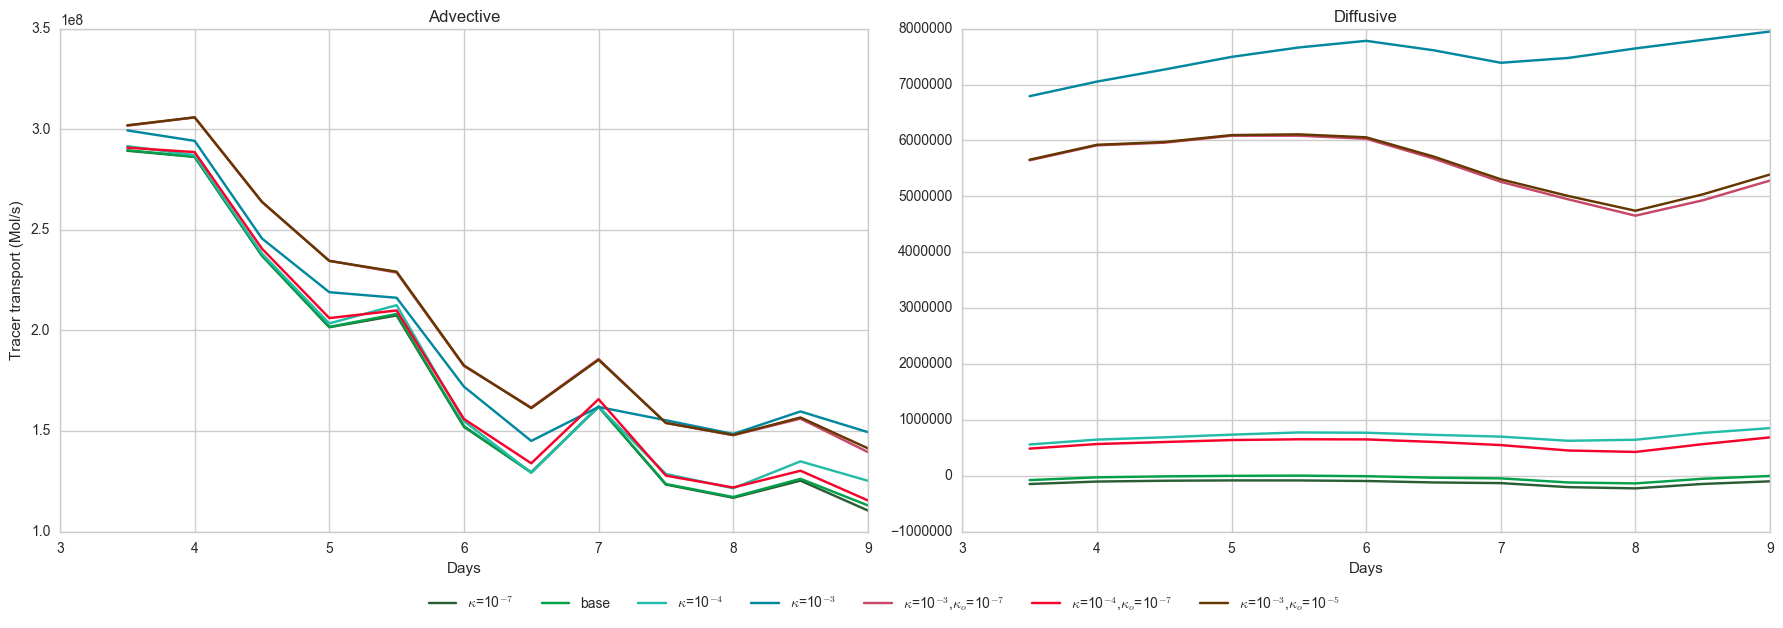

In [51]:
sns.set_context('notebook')
sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 2, figsize=(18,6))

time_vec = np.arange(7,19,1)/(2)

for ind in diff_ind:
    
    ax[0].plot(time_vec,(records[ind].advLID_flux.isel(T=slice(6,19)).data)*1000,'-',
               color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    ax[1].plot(time_vec,(records[ind].diffELID_flux.isel(T=slice(6,19)).data+
                         records[ind].diffILID_flux.isel(T=slice(6,19)).data)*1000,
               '-',color=sns.xkcd_rgb[records[ind].color],label=records[ind].label)
    
ax[0].set_title('Advective')
ax[1].set_title('Diffusive')

ax[0].set_xlabel('Days')
ax[1].set_xlabel('Days')

ax[0].set_ylabel('Tracer transport (Mol/s)')
ax[0].legend(bbox_to_anchor=(1.6,-0.1),ncol=7)
plt.tight_layout()
plt.show()